<a href="https://colab.research.google.com/github/olganikolaeva-hub/spark/blob/main/%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%B8_datafram%D0%BE%D0%B2_%D0%BD%D0%B0_PySpark_join%D1%8B_%D0%B0%D0%B3%D1%80%D0%B5%D0%B3%D0%B0%D1%82%D1%8B_%D1%8D%D0%BA%D1%81%D0%BF%D0%BE%D1%80%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создаём точку входа в Spark

In [1]:
import sys
import time

!pip install pyspark

#import findspark
#findspark.find()
#findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F


spark = SparkSession.builder \
    .master('local[*]')\
    .appName("Spark") \
    .config("spark.driver.memory", '2g') \
    .config("spark.executor.instances", 1) \
    .config("spark.executor.memory", "1024mb") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

sc = spark.sparkContext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 199 kB 51.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=97880cc56ebae5cd7fc5de525bd68c3ebc568442f1df3e40688ebca4d111a23e
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
# Вспомогательная функция
def beautiful_print(rdd, num, title):
    print(title)
    for row in rdd.take(num):
        print('\t', row)

In [3]:
spark

Требуется выяснить:
1. Какое соотношение сторон экрана телефона самое популярное,
2. Плотность пикселей у экрана.

Можно использовать только rdd.


## Считывание данных
Данные взяты отсюда: https://www.kaggle.com/iabhishekofficial/mobile-price-classification
Скачиваем и копируем в папку с нотебуком

Внутри содержится следующая информация:

* id: ID
* battery_power: Total energy a battery can store in one time (mAh)
* blue: Support bluetooth or not
* clock_speed: Speed at which microprocessor executes instructions
* dual_sim: Support dual sim or not
* fc: Front Camera mega pixels
* four_g: Support 4G or not
* int_memory: Internal Memory (GB)
* m_dep: Mobile Depth (cm)
* mobile_wt: Weight of mobile phone
* n_cores: Number of cores of processor
* pc: Primary Camera mega pixels
* px_height: Pixel Resolution Height
* px_width: Pixel Resolution Width
* ram: Random Access Memory (MB)
* sc_h: Screen Height of mobile (cm)
* sc_w: Screen Width of mobile (cm)
* talk_time: Time that a single battery charge will last
* three_g: Support 3G or not
* touch_screen: Has touch screen or not
* wifi: Support wifi or not

In [4]:
# Считываем данные
train = sc.textFile('/content/sample_data/train.csv')
test = sc.textFile('/content/sample_data/test.csv')

In [5]:
# Выводим содержимое каждого файла (часть строк)
print('Train')
print(train.take(10))
print('test')
print(test.take(10))
###############

Train
['battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range', '842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1', '1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2', '563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2', '615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2', '1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1', '1859,0,0.5,1,3,0,22,0.7,164,1,7,1004,1654,1067,17,1,10,1,0,0,1', '1821,0,1.7,0,4,1,10,0.8,139,8,10,381,1018,3220,13,8,18,1,0,1,3', '1954,0,0.5,1,0,0,24,0.8,187,4,0,512,1149,700,16,3,5,1,1,1,0', '1445,1,0.5,0,0,0,53,0.7,174,7,14,386,836,1099,17,1,20,1,0,0,0']
test
['id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi', '1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0', '2,841,

In [6]:
beautiful_print(train, 3, 'Train:')
beautiful_print(test, 3, 'Test:')

Train:
	 battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
	 842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
	 1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
Test:
	 id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
	 1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
	 2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0


In [54]:
#collect - плохая операция, забираем все данные на драйвер (вне кластера или внутри кластера)
test.collect()[:1]

[[1.0,
  1.8,
  1.0,
  14.0,
  0.0,
  5.0,
  0.1,
  193.0,
  3.0,
  16.0,
  226.0,
  1412.0,
  3476.0,
  12.0,
  7.0,
  2.0,
  0.0,
  1.0,
  0.0]]

In [8]:
test.collect()[:5]

['id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi',
 '1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0',
 '2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0',
 '3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1',
 '4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0']

Преобразуем train и test

Все функции расписаны тут: https://spark.apache.org/docs/latest/rdd-programming-guide.html. Так же хорошая статья тут

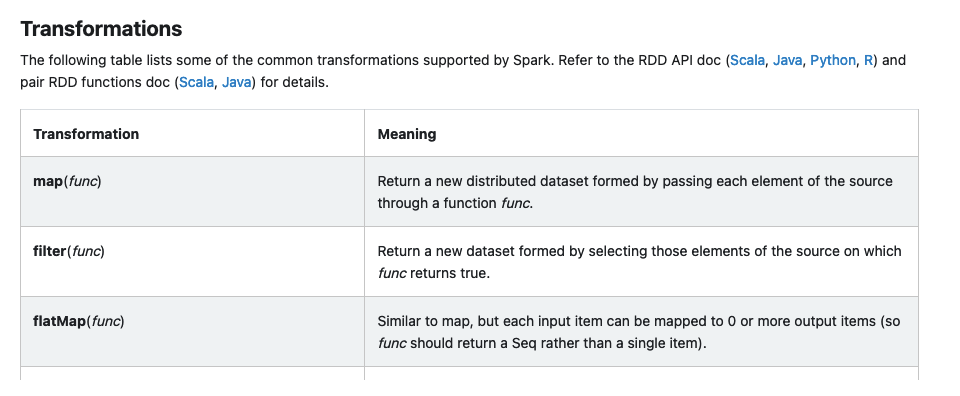

In [9]:
train_first_row = train.first()
train.filter(lambda row: row != train_first_row).take(10)

['842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1',
 '1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2',
 '563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2',
 '615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2',
 '1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1',
 '1859,0,0.5,1,3,0,22,0.7,164,1,7,1004,1654,1067,17,1,10,1,0,0,1',
 '1821,0,1.7,0,4,1,10,0.8,139,8,10,381,1018,3220,13,8,18,1,0,1,3',
 '1954,0,0.5,1,0,0,24,0.8,187,4,0,512,1149,700,16,3,5,1,1,1,0',
 '1445,1,0.5,0,0,0,53,0.7,174,7,14,386,836,1099,17,1,20,1,0,0,0',
 '509,1,0.6,1,2,1,9,0.1,93,5,15,1137,1224,513,19,10,12,1,0,0,0']

In [10]:
train_first_row = train.first()

train = train\
    .filter(lambda row: row != train_first_row)\
    .map(lambda row: [float(el) for el in row.split(',')])
print(f"Train size: {train.count()} x {len(train_first_row.split(','))}")

Train size: 2000 x 21


In [11]:
beautiful_print(train, 3, 'Train:')

Train:
	 [842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0, 1.0]
	 [1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0, 2.0]
	 [563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0, 2.0]


In [12]:
# Преобразуем test
###############
test_first_row = test.first()

test = test\
    .filter(lambda row: row != test_first_row)\
    .map(lambda row: [float(el) for el in row.split(',')])
print(f"Test size: {test.count()} x {len(test_first_row.split(','))}")
###############

Test size: 1000 x 21


In [13]:
print(train_first_row, '\n', test_first_row)
train_first_row == test_first_row

battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range 
 id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi


False

## Объединим train и test
Найти нужную функцию можно [здесь](https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.html#rdd-apis)

PS: нужно сделать средствами rdd pd.concat([train, test,], axis=0). Проверьте, что union вышел правильно

In [14]:
# Объедините train и test
###############
data = train.union(test)
print('Общее количество строк', data.count())
###############

Общее количество строк 3000


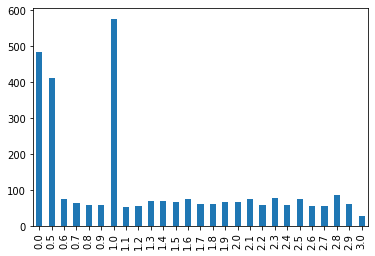

In [15]:
import pandas as pd

#либо такие данные? не видим ни нормального распределения, ни гамма-распределения, вероятно, ошибка в таблицах...
pd.Series(data.map(lambda row: (row[2], 1)).countByKey()).sort_index().plot.bar()

In [16]:
#видим нарушение консистентности данных
train_header = train_first_row.split(',')
test_header = test_first_row.split(',')
print('Количество колонок в трейн', len(train_header), 'Количество колонок в тест', len(test_header))
print('Общие колонки', set(train_header) | set(test_header))
print('Отличия в заголовках - трейн от тест', set(train_header) - set(test_header))
print('Отличия в заголовках - тест от трейн', set(test_header) - set(train_header))

diff = lambda l1,l2: filter(lambda x: x not in l2, l1)
print('Отличия в заголовках', list(diff(train_header, test_header)), list(diff(test_header, train_header)))

Количество колонок в трейн 21 Количество колонок в тест 21
Общие колонки {'four_g', 'clock_speed', 'talk_time', 'fc', 'three_g', 'wifi', 'sc_w', 'n_cores', 'mobile_wt', 'battery_power', 'ram', 'price_range', 'pc', 'px_height', 'dual_sim', 'touch_screen', 'm_dep', 'id', 'blue', 'int_memory', 'px_width', 'sc_h'}
Отличия в заголовках - трейн от тест {'price_range'}
Отличия в заголовках - тест от трейн {'id'}
Отличия в заголовках ['price_range'] ['id']


In [34]:
train = train.map(lambda row: row[:-1])
test = test.map(lambda row: row[1:])
data = train.union(test)
print('Общее количество строк', data.count())

Общее количество строк 3000


In [35]:
#как еще можно объединять таблицы:
#df.UnionByName(df1)
#df.select(*columns).UnionByName(df2.select(*columns))

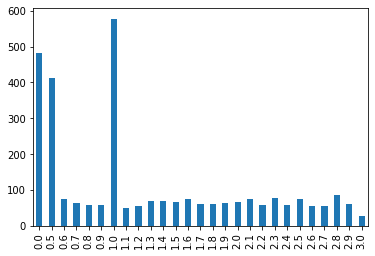

In [36]:
#большинство телефонов слабые, но есть часть и сильных
pd.Series(data.map(lambda row: (row[2], 1)).countByKey()).sort_index().plot.bar()

In [37]:
## Рассчитайте соотношение сторон телефона и экрана

## Хотим рассчитать соотношение сторон телефона и экрана

In [38]:
sc_h = train_header.index('sc_h')
sc_w = train_header.index('sc_w')
sc_h, sc_w

(14, 15)

2708


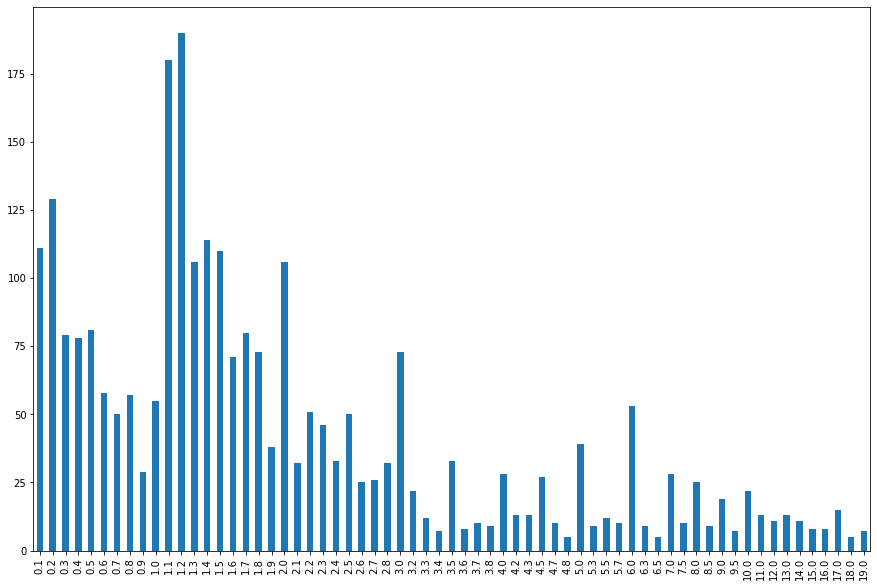

In [39]:
# Выводим отсортированное распределение соотношений сторон экрана
# в разрезе широкоформатные или нет (экран широкоформатный, если соотношение >=16:9)
###############
#делаем структуру key value
tmp = data.map(lambda row: (row[sc_h], row[sc_w]))\
    .filter(lambda row: row[0] > 0)\
    .filter(lambda row: row[1] > 0)\
    .map(lambda row: (round(row[0] / row[1], 1), 1))

print(tmp.count())
pd.Series(tmp.countByKey()).sort_index().plot.bar(figsize=(15, 10))
###############

#видим, что много квадратных телефонов, у которых соотношение сторон 1.1, также есть и сильно вытянутые
#(неинтерпретируемые данные, выбросы)

In [40]:
train_header

['battery_power',
 'blue',
 'clock_speed',
 'dual_sim',
 'fc',
 'four_g',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time',
 'three_g',
 'touch_screen',
 'wifi',
 'price_range']

2707


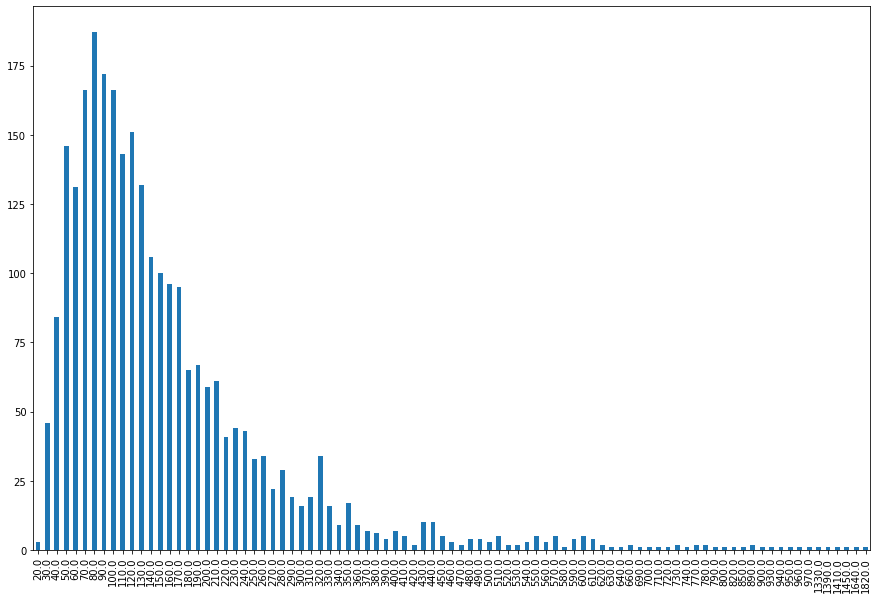

In [41]:
# Выводим отсортированное распределение плотности пикселей
# точек на дюйм (ppi)
###############
sc_h = train_header.index('sc_h')
sc_w = train_header.index('sc_w')
px_height = train_header.index('px_height')
px_width = train_header.index('px_width')

def calc_ppi(sc_h, sc_w, px_h, px_w):
    px_diag = (px_h ** 2 + px_w ** 2) ** (1/2)
    sc_diag = (sc_h ** 2 + sc_w ** 2) ** (1/2)
    return px_diag / sc_diag
    

tmp = data.map(lambda row: (row[sc_h], row[sc_w], row[px_height], row[px_width],))\
    .filter(lambda row: row[0] > 0)\
    .filter(lambda row: row[1] > 0)\
    .filter(lambda row: row[2] > 0)\
    .filter(lambda row: row[3] > 0)\
    .map(lambda row: (round(calc_ppi(*row) / 10, 0) * 10 , 1))

print(tmp.count())
#countByKey - возвращает питоновский объект
pd.Series(tmp.countByKey()).sort_index().plot.bar(figsize=(15, 10))
###############

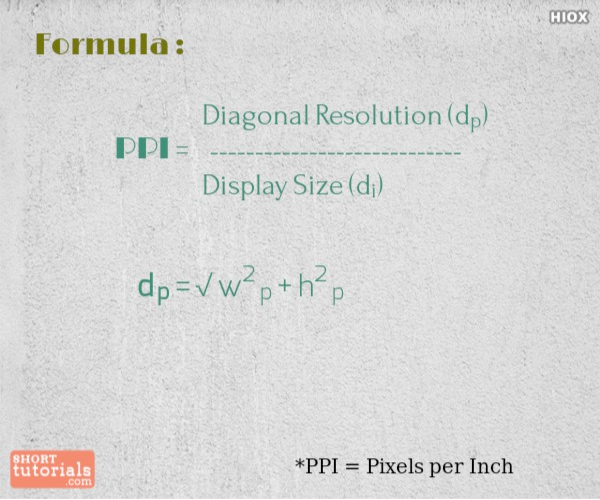

# JOIN
Можно сделать и так:

Пример для двух RDDs: (rdd = {(1, 2), (3, 4), (3, 6)} other = {(3, 9)})

Имя функции |	Purpose |	Example |	Result
------------- |	------- |	------- |	------
subtractByKey |Remove elements with a key present in the other RDD.| rdd.subtractByKey(other) | {(1, 2)}
join | Perform an inner join between two RDDs. | rdd.join(other) | {(3, (4, 9)), (3, (6, 9))}
rightOuterJoin | Perform a join between two RDDs where the key must be present in the first RDD. | rdd.rightOuterJoin(other) | {(3,(Some(4),9)), (3,(Some(6),9))}leftOuterJoin | Perform a join between two RDDs where the key must be present in the other RDD. | rdd.leftOuterJoin(other) | {(1,(2,None)), (3,(4,Some(9))), (3,(6,Some(9)))}
cogroup | Group data from both RDDs sharing the same key. | rdd.cogroup(other) | {(1,([2],[])), (3,([4, 6],[9]))}

In [42]:
sc_h = train_header.index('sc_h')
sc_w = train_header.index('sc_w')
px_height = train_header.index('px_height')
px_width = train_header.index('px_width')

def calc_ppi(sc_h, sc_w, px_h, px_w):
    px_diag = (px_h ** 2 + px_w ** 2) ** (1/2)
    sc_diag = (sc_h ** 2 + sc_w ** 2) ** (1/2)
    return px_diag / sc_diag

def get_rdd_ppi(rdd):
    return rdd.map(lambda row: (row[sc_h], row[sc_w], row[px_height], row[px_width],))\
    .filter(lambda row: row[0] > 0)\
    .filter(lambda row: row[1] > 0)\
    .filter(lambda row: row[2] > 0)\
    .filter(lambda row: row[3] > 0)\
    .map(lambda row: (round(calc_ppi(*row) / 10, 0) * 10 , 1))\
    .reduceByKey(lambda a, b: a + b)

In [43]:
train_tmp = get_rdd_ppi(train)
test_tmp = get_rdd_ppi(test)

In [44]:
test_tmp

PythonRDD[73] at RDD at PythonRDD.scala:53

In [45]:
train_tmp.join(test_tmp).take(5)

[(70.0, (147, 19)),
 (130.0, (102, 30)),
 (190.0, (29, 38)),
 (120.0, (102, 49)),
 (210.0, (30, 31))]

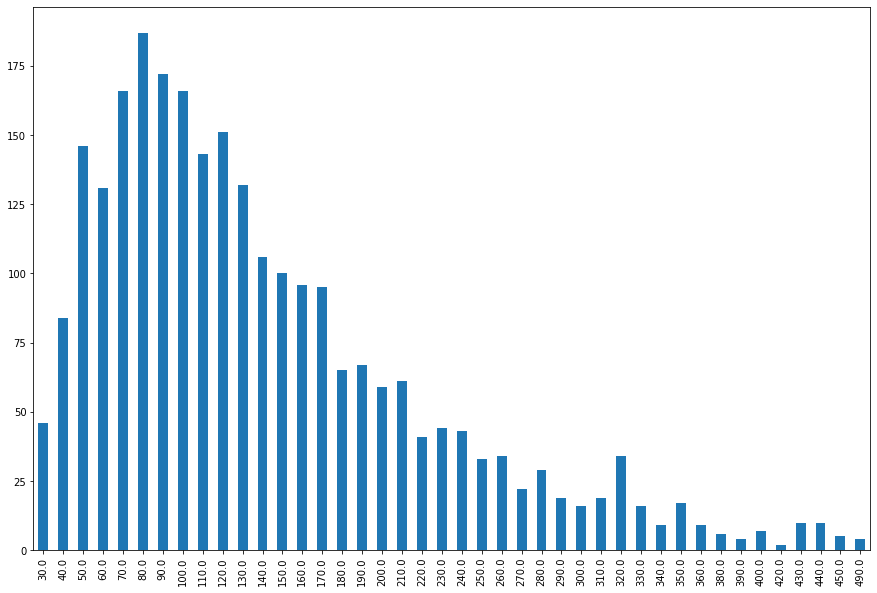

In [46]:
#только те ключи, которые были в обеих таблицах(коллекциях данных)
#в первом варианте хвост был длинне
a = train_tmp.join(test_tmp).map(lambda row: (row[0], sum(row[1]))).collect()
pd.Series([x[1] for x in a], index=[x[0] for x in a]).sort_index().plot.bar(figsize=(15, 10))

In [ ]:
type(a)

list

In [47]:
train_tmp.cogroup(test_tmp).take(5)

[(70.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f6271425110>,
   <pyspark.resultiterable.ResultIterable at 0x7f6271425c50>)),
 (130.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f6271425e90>,
   <pyspark.resultiterable.ResultIterable at 0x7f6271425850>)),
 (190.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f62719ef690>,
   <pyspark.resultiterable.ResultIterable at 0x7f6271420090>)),
 (120.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f6271425590>,
   <pyspark.resultiterable.ResultIterable at 0x7f6271afd610>)),
 (210.0,
  (<pyspark.resultiterable.ResultIterable at 0x7f62713b3b90>,
   <pyspark.resultiterable.ResultIterable at 0x7f62713b3c50>))]

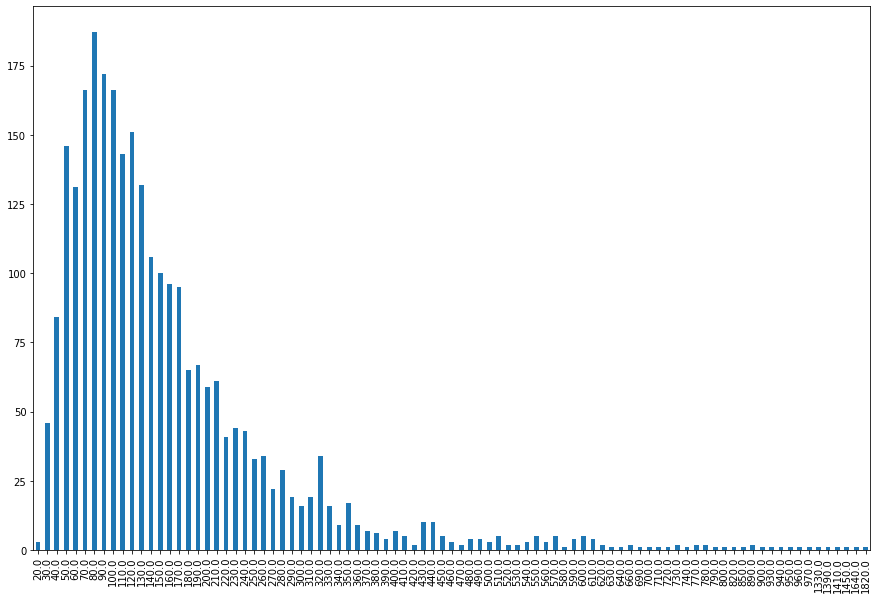

In [48]:
#обратное innery (только те ключи, которые есть в таблице, но нет в другой)
a = train_tmp.cogroup(test_tmp).map(lambda row: (row[0], sum(list(row[1][0])) + sum(list(row[1][1])))).collect()
pd.Series([x[1] for x in a], index=[x[0] for x in a]).sort_index().plot.bar(figsize=(15, 10))

In [32]:
train_tmp = tmp.countByKey()
test_tmp  = tmp.countByKey()

## Сохранение

In [49]:
final_result = train_tmp.cogroup(test_tmp).map(lambda row: (row[0], sum(list(row[1][0])) + sum(list(row[1][1]))))

In [50]:
final_result.take(2)

[(70.0, 166), (130.0, 132)]

In [51]:
#появляется папка result.csv с кол-во файлов, соответствующим кол-ву партиций
final_result.map(lambda row: ';'.join(map(str, row))).saveAsTextFile('result.csv')

In [ ]:
#как еще можно было бы сделать:
#rdd.union(text_rdd).map(f)
#repartition делает 1 партицию!

In [52]:
!rm -r result.csv

sc.parallelize(['key;value_ppi'])\
.union(final_result.map(lambda row: ';'.join(map(str, row)))).repartition(1).saveAsTextFile('result.csv')

In [ ]:
#coalesce - с помощью coalesce тоже можно уменьшать кол-во партиций